In [1]:
print(">>> [Test Cell 02] Bắt đầu chạy...")

import pandas as pd
import numpy as np
import os
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
# Import mô hình từ logic của đồng đội
from sklearn.neighbors import KNeighborsRegressor 
# Import các hàm metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

# --- Bỏ qua các cảnh báo (cho gọn) ---
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

>>> [Test Cell 02] Bắt đầu chạy...


In [2]:
print("[Cell] Đang thiết lập cấu hình...")

# SỬA LỖI PATH: Dùng os.getcwd() thay vì __file__
try:
    # Giả định notebook này nằm trong thư mục /notebooks
    CURRENT_DIR = os.getcwd() 
    ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
    
    # Định nghĩa các đường dẫn
    PROCESSED_DATA_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'dataset_clean.csv')
    REPORTS_DIR = os.path.join(ROOT_DIR, 'reports')
    FIGURES_DIR = os.path.join(REPORTS_DIR, 'figures')
    RESULTS_DIR = os.path.join(REPORTS_DIR, 'results')
    
    # Hằng số
    RANDOM_STATE = 42
    TEST_SIZE = 0.3
    
    print(f"Đường dẫn file dữ liệu: {PROCESSED_DATA_PATH}")

except Exception as e:
    print(f"Lỗi khi thiết lập đường dẫn: {e}")
    print("Hãy đảm bảo bạn đang chạy notebook này từ thư mục /notebooks")

[Cell] Đang thiết lập cấu hình...
Đường dẫn file dữ liệu: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv


In [3]:
print("[Cell] Đang định nghĩa các hàm mô hình...")

def get_knn(n_neighbors=5): 
    """Logic từ: src/models/knn/knn_model.py (dùng k=5)"""
    # Dùng KNeighborsRegressor từ sklearn như trong file .ipynb của đồng đội
    return KNeighborsRegressor(n_neighbors=n_neighbors)

def apply_pca(X_train, X_test, n_components=0.95):
    """Logic từ: src/feature_engineering/pca/pca_logic.py"""
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"PCA: Đã giảm từ {X_train.shape[1]} xuống {pca.n_components_} chiều.")
    return X_train_pca, X_test_pca

[Cell] Đang định nghĩa các hàm mô hình...


In [4]:
print("[Cell] Đang định nghĩa hàm đánh giá...")

# *** ĐÃ CẬP NHẬT (Thêm MSE + RMSE) ***
def get_regression_metrics(y_true, y_pred, title="Model"):
    """
    Tính toán, in và lưu báo cáo hồi quy, vẽ biểu đồ phân tán.
    """
    y_true_np = y_true.to_numpy() if isinstance(y_true, pd.Series) else np.array(y_true).ravel()
    y_pred_np = np.array(y_pred).ravel()

    r2 = r2_score(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np) # TÍNH TOÁN MSE
    rmse = np.sqrt(mse) # TÍNH TOÁN RMSE
    
    print("\n" + "-"*30)
    print(f"KẾT QUẢ ĐÁNH GIÁ CHO: {title}")
    print(f"R-Squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}") # IN MSE
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}") # IN RMSE
    print("-" * 30)

    # ... (Toàn bộ code vẽ biểu đồ giữ nguyên) ...
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true_np, y=y_pred_np, alpha=0.5)
    lims = [np.min([plt.xlim(), plt.ylim()]), np.max([plt.xlim(), plt.ylim()])]
    plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0) 
    plt.title(f'Predicted vs. Actual - {title}')
    plt.xlabel('Giá trị Thực tế (Actual Revenue)')
    plt.ylabel('Giá trị Dự đoán (Predicted Revenue)')
    plt.xlim(lims)
    plt.ylim(lims)
    
    os.makedirs(FIGURES_DIR, exist_ok=True)
    fig_path = os.path.join(FIGURES_DIR, f'scatter_{title.lower().replace(" ", "_")}.png')
    
    try:
        plt.savefig(fig_path)
        print(f"Đã lưu biểu đồ phân tán tại: {fig_path}")
    except Exception as e:
        print(f"Lỗi khi lưu hình ảnh: {e}")
        
    plt.show() 
    
    # THÊM MSE/RMSE VÀO KẾT QUẢ TRẢ VỀ
    return {"R-Squared": r2, "MAE": mae, "MSE": mse, "RMSE": rmse}


[Cell] Đang định nghĩa hàm đánh giá...


In [5]:
print("\n[Cell] Đang tải và chuẩn bị dữ liệu...")

if not os.path.exists(PROCESSED_DATA_PATH):
    print(f"LỖI: Không tìm thấy file {PROCESSED_DATA_PATH}")
    print("Vui lòng chạy 'python src/data_processing.py' trước để tạo file này.")
else:
    print(f"Đang tải dữ liệu đã xử lý từ: {PROCESSED_DATA_PATH}")
    data = pd.read_csv(PROCESSED_DATA_PATH)

    target_col = 'Revenue_(USD)' 
    X = data.drop(columns=[target_col])
    y = data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, 
        random_state=RANDOM_STATE
    )

    # --- Scale Dữ liệu X (Sử dụng RobustScaler) ---
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Chuẩn bị dữ liệu hoàn tất.")


[Cell] Đang tải và chuẩn bị dữ liệu...
Đang tải dữ liệu đã xử lý từ: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\data\processed\dataset_clean.csv
Chuẩn bị dữ liệu hoàn tất.



[Cell] Đang huấn luyện: 1. KNN (Full Features)...

------------------------------
KẾT QUẢ ĐÁNH GIÁ CHO: KNN_(Full)
R-Squared (R²): 0.9812
Mean Absolute Error (MAE): 2.2358
Mean Squared Error (MSE): 39.1332
Root Mean Squared Error (RMSE): 6.2556
------------------------------
Đã lưu biểu đồ phân tán tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\figures\scatter_knn_(full).png


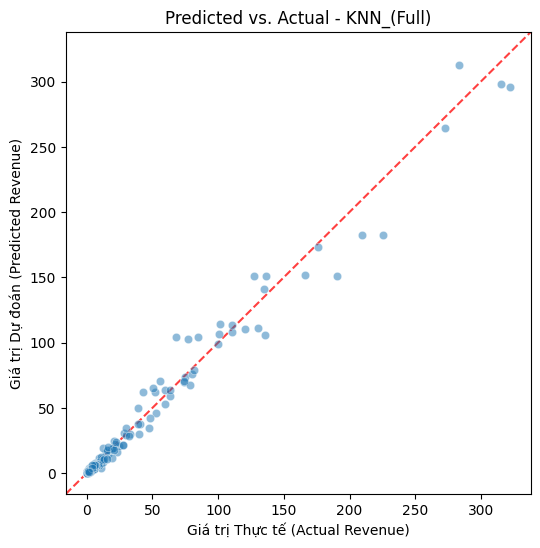

In [6]:
results_list = [] 

# --- Kịch bản 1: Full Features ---
print("\n[Cell] Đang huấn luyện: 1. KNN (Full Features)...")

knn_full = get_knn() # Dùng k=5 mặc định từ file của đồng đội
knn_full.fit(X_train_scaled, y_train) # Fit trên y_train gốc
y_pred_knn_full = knn_full.predict(X_test_scaled)

metrics_knn_full = get_regression_metrics(y_test, y_pred_knn_full, title="KNN_(Full)")

# *** ĐÃ CẬP NHẬT (Thêm MSE + RMSE) ***
results_list.append({
    'Model': 'KNN',
    'Features': 'Full',
    'R-Squared': metrics_knn_full['R-Squared'],
    'MAE': metrics_knn_full['MAE'],
    'MSE': metrics_knn_full['MSE'], # THÊM
    'RMSE': metrics_knn_full['RMSE'] # THÊM
})


[Cell] Đang huấn luyện: 2. KNN (PCA Features)...
PCA: Đã giảm từ 13 xuống 2 chiều.

------------------------------
KẾT QUẢ ĐÁNH GIÁ CHO: KNN_(PCA)
R-Squared (R²): 0.9759
Mean Absolute Error (MAE): 2.6676
Mean Squared Error (MSE): 50.1321
Root Mean Squared Error (RMSE): 7.0804
------------------------------
Đã lưu biểu đồ phân tán tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\figures\scatter_knn_(pca).png


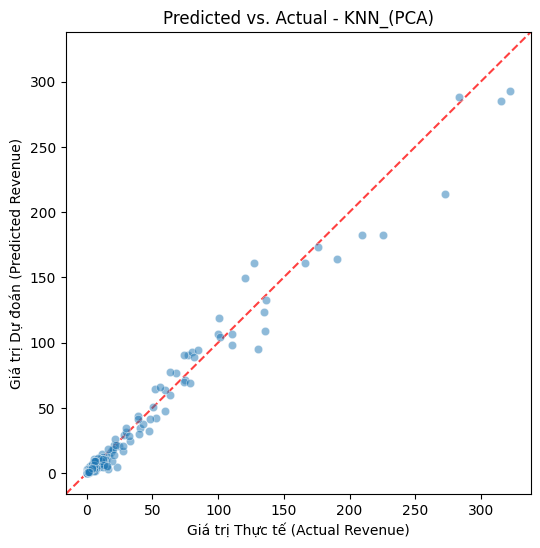

In [7]:
print("\n[Cell] Đang huấn luyện: 2. KNN (PCA Features)...")

# Áp dụng PCA
X_train_pca_unscaled, X_test_pca_unscaled = apply_pca(X_train_scaled, X_test_scaled, n_components=0.95)

# Scale lại đầu ra PCA
pca_scaler = RobustScaler()
X_train_pca_scaled = pca_scaler.fit_transform(X_train_pca_unscaled)
X_test_pca_scaled = pca_scaler.transform(X_test_pca_unscaled)

knn_pca = get_knn()
knn_pca.fit(X_train_pca_scaled, y_train) # Fit trên y_train gốc
y_pred_knn_pca = knn_pca.predict(X_test_pca_scaled)

metrics_knn_pca = get_regression_metrics(y_test, y_pred_knn_pca, title="KNN_(PCA)")

# *** ĐÃ CẬP NHẬT (Thêm MSE + RMSE) ***
results_list.append({
    'Model': 'KNN',
    'Features': 'PCA',
    'R-Squared': metrics_knn_pca['R-Squared'],
    'MAE': metrics_knn_pca['MAE'],
    'MSE': metrics_knn_pca['MSE'], # THÊM
    'RMSE': metrics_knn_pca['RMSE'] # THÊM
})

In [8]:
print("\n[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...")

os.makedirs(RESULTS_DIR, exist_ok=True)
# LƯU VÀO FILE RIÊNG
output_path = os.path.join(RESULTS_DIR, 'knn_results.json')

with open(output_path, 'w') as f:
    json.dump(results_list, f, indent=4)
    
print(f"Đã lưu kết quả của KNN tại: {output_path}")

print("\nBảng kết quả tổng hợp (KNN):")
display(pd.DataFrame(results_list))

print("\n>>> [Test Cell 02] Đã chạy xong.")


[Cell] HOÀN TẤT: Lưu kết quả ra file JSON...
Đã lưu kết quả của KNN tại: c:\Users\Admin\OneDrive\Documents\Vscode\Student\ML\Midterm\Chau\reports\results\knn_results.json

Bảng kết quả tổng hợp (KNN):


,Model,Features,R-Squared,MAE,MSE,RMSE
0,KNN,Full,0.981210,2.235819,39.133150,6.255649
1,KNN,PCA,0.975929,2.667587,50.132088,7.080402



>>> [Test Cell 02] Đã chạy xong.
